In [1]:
import warnings

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import pytensor
from pymc.model.transform.optimization import freeze_dims_and_data

from pymc_marketing.mmm import GeometricAdstock, MichaelisMentenSaturation
from pymc_marketing.mmm.multidimensional import MMM

In [2]:
warnings.filterwarnings("ignore", category=FutureWarning)

az.style.use("arviz-darkgrid")
plt.rcParams["figure.figsize"] = [13, 15]
plt.rcParams["figure.dpi"] = 100
plt.rcParams["xtick.labelsize"] = 10
plt.rcParams["ytick.labelsize"] = 8

%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

In [3]:
MMM

pymc_marketing.mmm.multidimensional.MMM

In [4]:
GeometricAdstock

pymc_marketing.mmm.components.adstock.GeometricAdstock

In [5]:
# Generate a date range
date_range = pd.date_range(start="2023-01-01", end="2023-01-10")

# Define countries and channels
countries = ["Venezuela", "Colombia", "Chile", "Argentina"]
channels = ["a", "b"]

# Create a DataFrame
data = []
for country in countries:
    for date in date_range:
        record = [date, country, *list(np.random.randint(100, 500, size=len(channels)))]
        data.append(record)

df = pd.DataFrame(data, columns=["date", "country", *channels])
df["target"] = df[channels].sum(axis=1) + np.random.randint(100, 500, size=len(df))
df.head()

,date,country,a,b,target
0,2023-01-01,Venezuela,178,149,774
1,2023-01-02,Venezuela,230,117,593
2,2023-01-03,Venezuela,300,477,1050
3,2023-01-04,Venezuela,417,208,952
4,2023-01-05,Venezuela,452,389,1236


In [6]:
from pymc_marketing.prior import Prior

# Strange error here.
hierarchical_alpha = Prior(
    "Gamma",
    mu=Prior("HalfNormal", sigma=1, dims="country"),
    sigma=Prior("HalfNormal", sigma=1, dims="country"),
    dims=("channel", "country"),
)
common_lam = Prior("HalfNormal", sigma=1, dims=("channel",))
priors = {
    "alpha": hierarchical_alpha,
    "lam": common_lam,
}

# Not working with hierarchical priors

In [7]:
# Strange error here.
hierarchical_alpha = Prior(
    "Gamma",
    mu=Prior("HalfNormal", sigma=1, dims="country"),
    sigma=Prior("HalfNormal", sigma=1, dims="country"),
    dims=("channel", "country"),
)
common_lam = Prior("HalfNormal", sigma=1, dims=("channel",))
priors = {
    "alpha": hierarchical_alpha,
    "lam": common_lam,
}

saturation = MichaelisMentenSaturation(priors=priors)

In [8]:
saturation.model_config

{'saturation_alpha': Prior("Gamma", mu=Prior("HalfNormal", sigma=1, dims="country"), sigma=Prior("HalfNormal", sigma=1, dims="country"), dims=("channel", "country")),
 'saturation_lam': Prior("HalfNormal", sigma=1, dims="channel")}

In [9]:
alpha = Prior("HalfNormal", sigma=1, dims="channel")
adstock = GeometricAdstock(l_max=2)
adstock.model_config

{'adstock_alpha': Prior("Beta", alpha=1, beta=3)}

In [10]:
mmm = MMM(
    date_column="date",
    target_column="target",
    channel_columns=["a", "b"],
    dims=("country",),
    adstock=adstock,
    saturation=saturation,
    yearly_seasonality=12,
    time_varying_media=True,
    time_varying_intercept=True,
)

In [11]:
mmm.build_model(X=df.drop(columns="target"), y=df.drop(columns=channels))

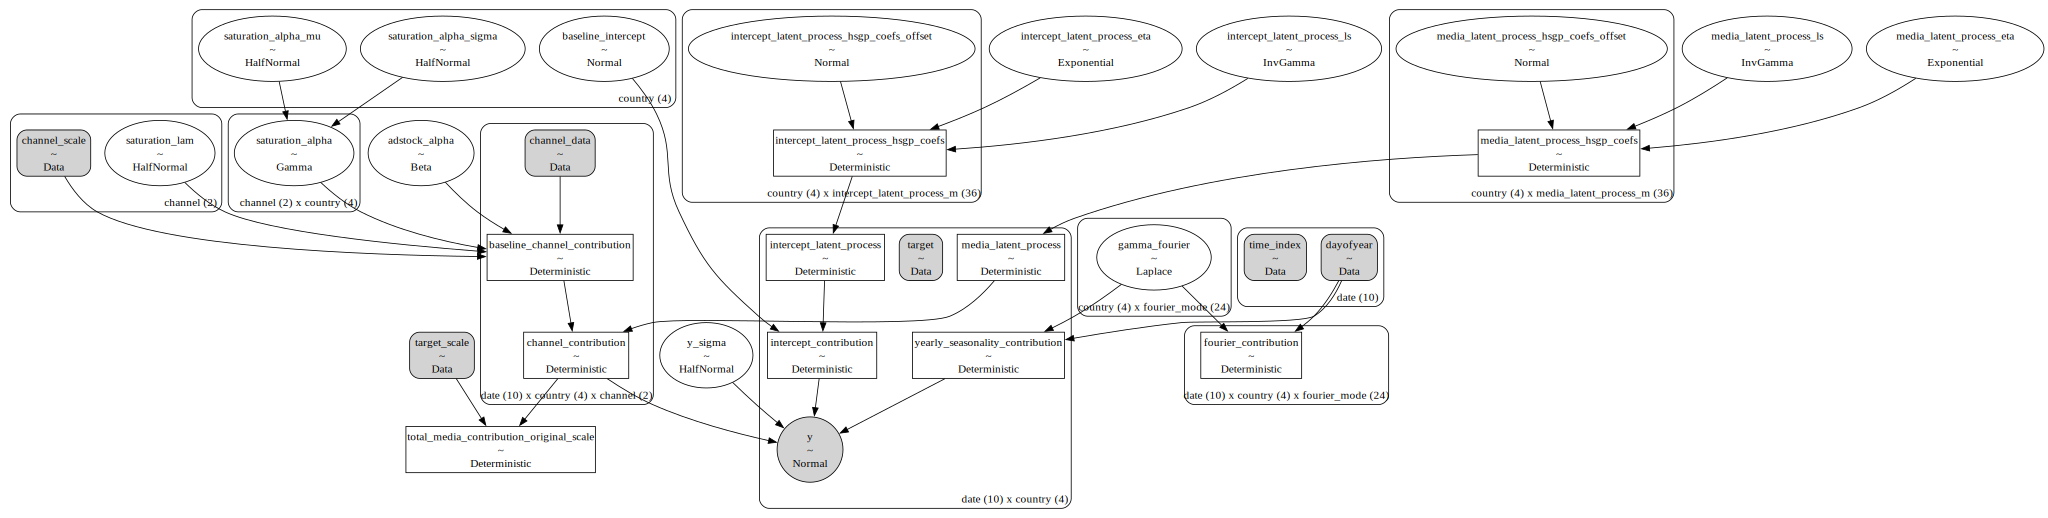

In [12]:
pm.model_to_graphviz(mmm.model)

In [13]:
mmm.add_original_scale_contribution_variable(
    var=["intercept_contribution", "channel_contribution"]
)

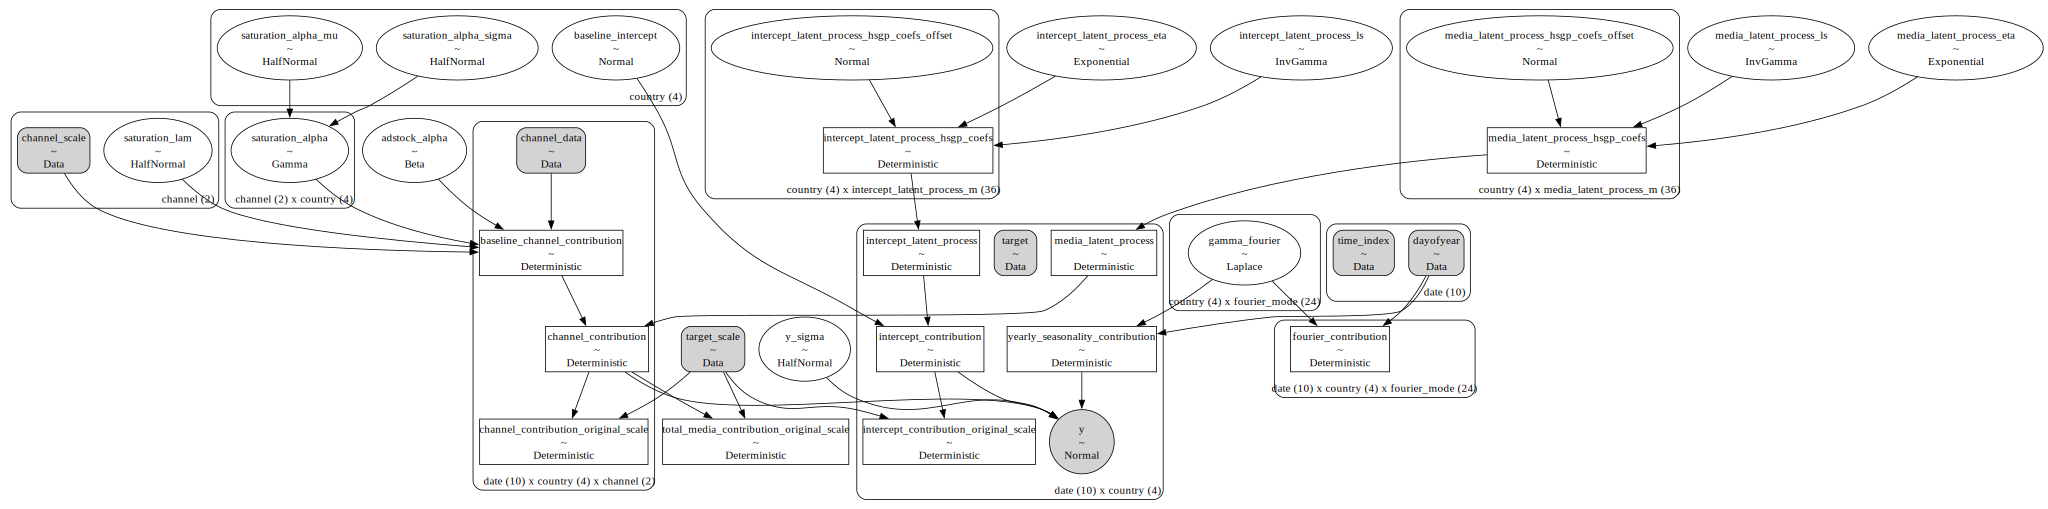

In [14]:
pm.model_to_graphviz(mmm.model)

In [15]:
pytensor.dprint(
    freeze_dims_and_data(mmm.model)["channel_contribution_original_scale"],
    depth=4,
    print_type=True,
)

Mul [id A] <Tensor3(float64, shape=(10, 4, 2))> 'channel_contribution_original_scale'
 ├─ Mul [id B] <Tensor3(float64, shape=(10, 4, 2))> 'channel_contribution'
 │  ├─ True_div [id C] <Tensor3(float64, shape=(10, 4, 2))> 'baseline_channel_contribution'
 │  │  ├─ Mul [id D] <Tensor3(float64, shape=(10, 4, 2))>
 │  │  └─ Add [id E] <Tensor3(float64, shape=(10, 4, 2))>
 │  └─ ExpandDims{axis=2} [id F] <Tensor3(float64, shape=(10, 4, 1))>
 │     └─ Blockwise{dot, (m,k),(k,n)->(m,n)} [id G] <Matrix(float64, shape=(10, 4))> 'media_latent_process'
 └─ ExpandDims{axes=[0, 1, 2]} [id H] <Tensor3(float64, shape=(1, 1, 1))>
    └─ target_scale{1394.0} [id I] <Scalar(float64, shape=())>


In [16]:
mmm.fit(
    X=df.drop(columns="target"),
    y=df.drop(columns=channels),
    chains=4,
    target_accept=0.85,
    nuts_sampler="numpyro",
)

mmm.sample_posterior_predictive(X=df.drop(columns="target"), y=None)

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

2025-01-31 13:22:28.794813: E external/xla/xla/service/slow_operation_alarm.cc:65] Constant folding an instruction is taking > 1s:

  %reduce.11 = f64[4,1000,10,4,2]{4,3,2,1,0} reduce(f64[4,1000,1,10,4,2]{5,4,3,2,1,0} %broadcast.16, f64[] %constant.31), dimensions={2}, to_apply=%region_7.208, metadata={op_name="jit(process_fn)/jit(main)/reduce_prod" source_file="/var/folders/f0/rbz8xs8s17n3k3f_ccp31bvh0000gn/T/tmpvgvl1ege" source_line=145}

This isn't necessarily a bug; constant-folding is inherently a trade-off between compilation time and speed at runtime. XLA has some guards that attempt to keep constant folding from taking too long, but fundamentally you'll always be able to come up with an input program that takes a long time.

If you'd like to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
2025-01-31 13:22:29.176898: E external/xla/xla/service/slow_operation_alarm.cc:133] The operation took 1.387126s
Constant folding an instruction is taking 

Output()

<xarray.Dataset> Size: 1MB
Dimensions:  (date: 10, country: 4, sample: 4000)
Coordinates:
  * date     (date) datetime64[ns] 80B 2023-01-01 2023-01-02 ... 2023-01-10
  * country  (country) <U9 144B 'Argentina' 'Chile' 'Colombia' 'Venezuela'
  * sample   (sample) object 32kB MultiIndex
  * chain    (sample) int64 32kB 0 0 0 0 0 0 0 0 0 0 0 ... 3 3 3 3 3 3 3 3 3 3 3
  * draw     (sample) int64 32kB 0 1 2 3 4 5 6 7 ... 993 994 995 996 997 998 999
Data variables:
    y        (date, country, sample) float64 1MB 0.7767 0.4124 ... 0.5087 0.5769
Attributes:
    created_at:                 2025-01-31T11:22:30.192508+00:00
    arviz_version:              0.20.0
    inference_library:          pymc
    inference_library_version:  5.20.0

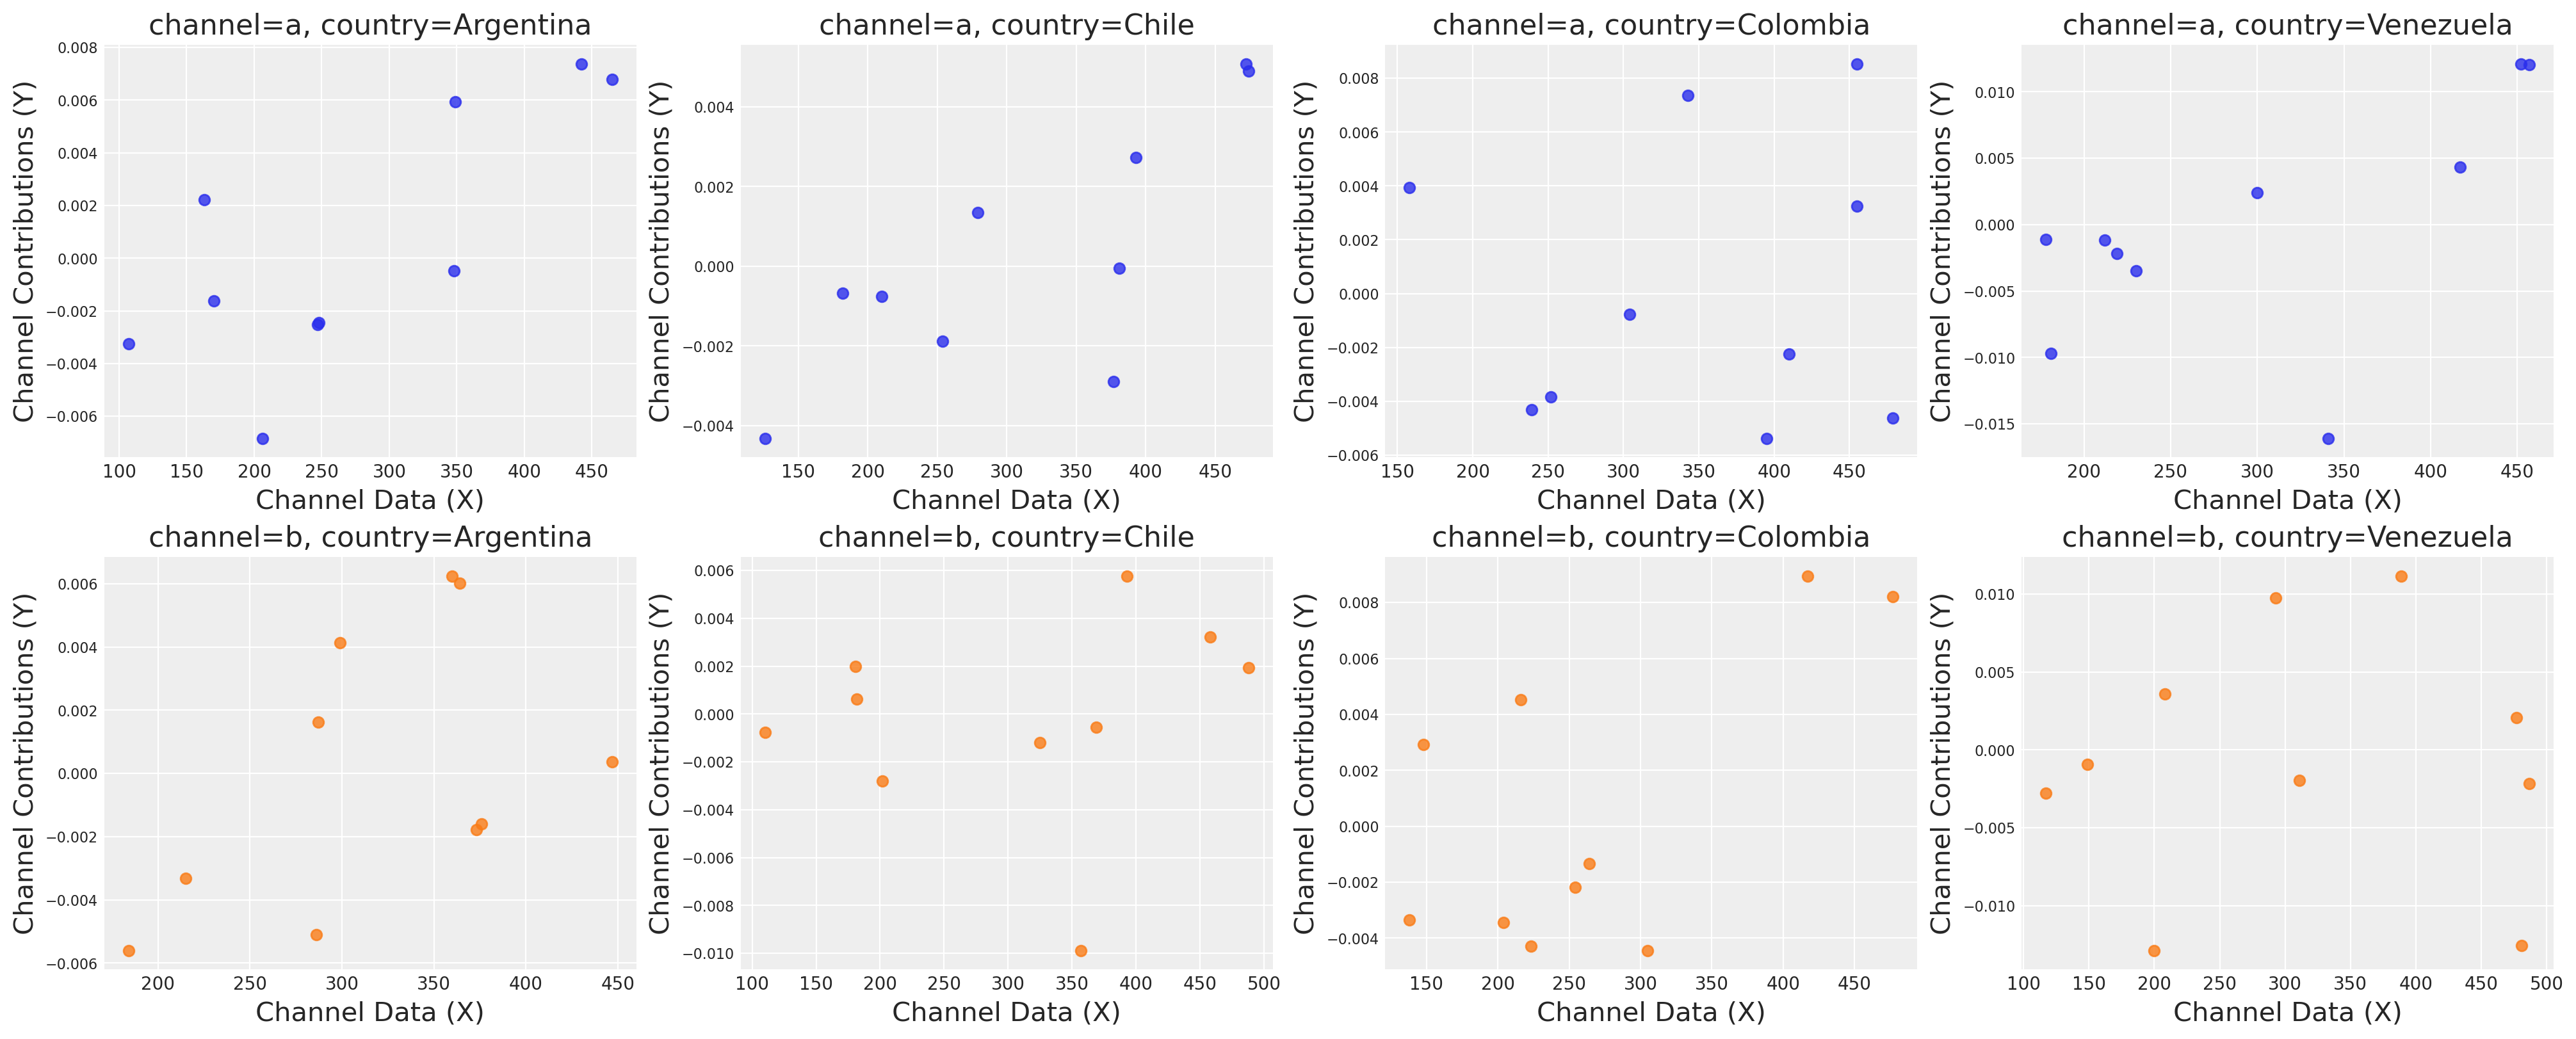

In [17]:
mmm.plot.saturation_curves_scatter();

In [18]:
_y_in_sample = mmm.sample_posterior_predictive(
    X=df.drop(columns="target"), y=None, extend_idata=False
)

Sampling: [y]


Output()

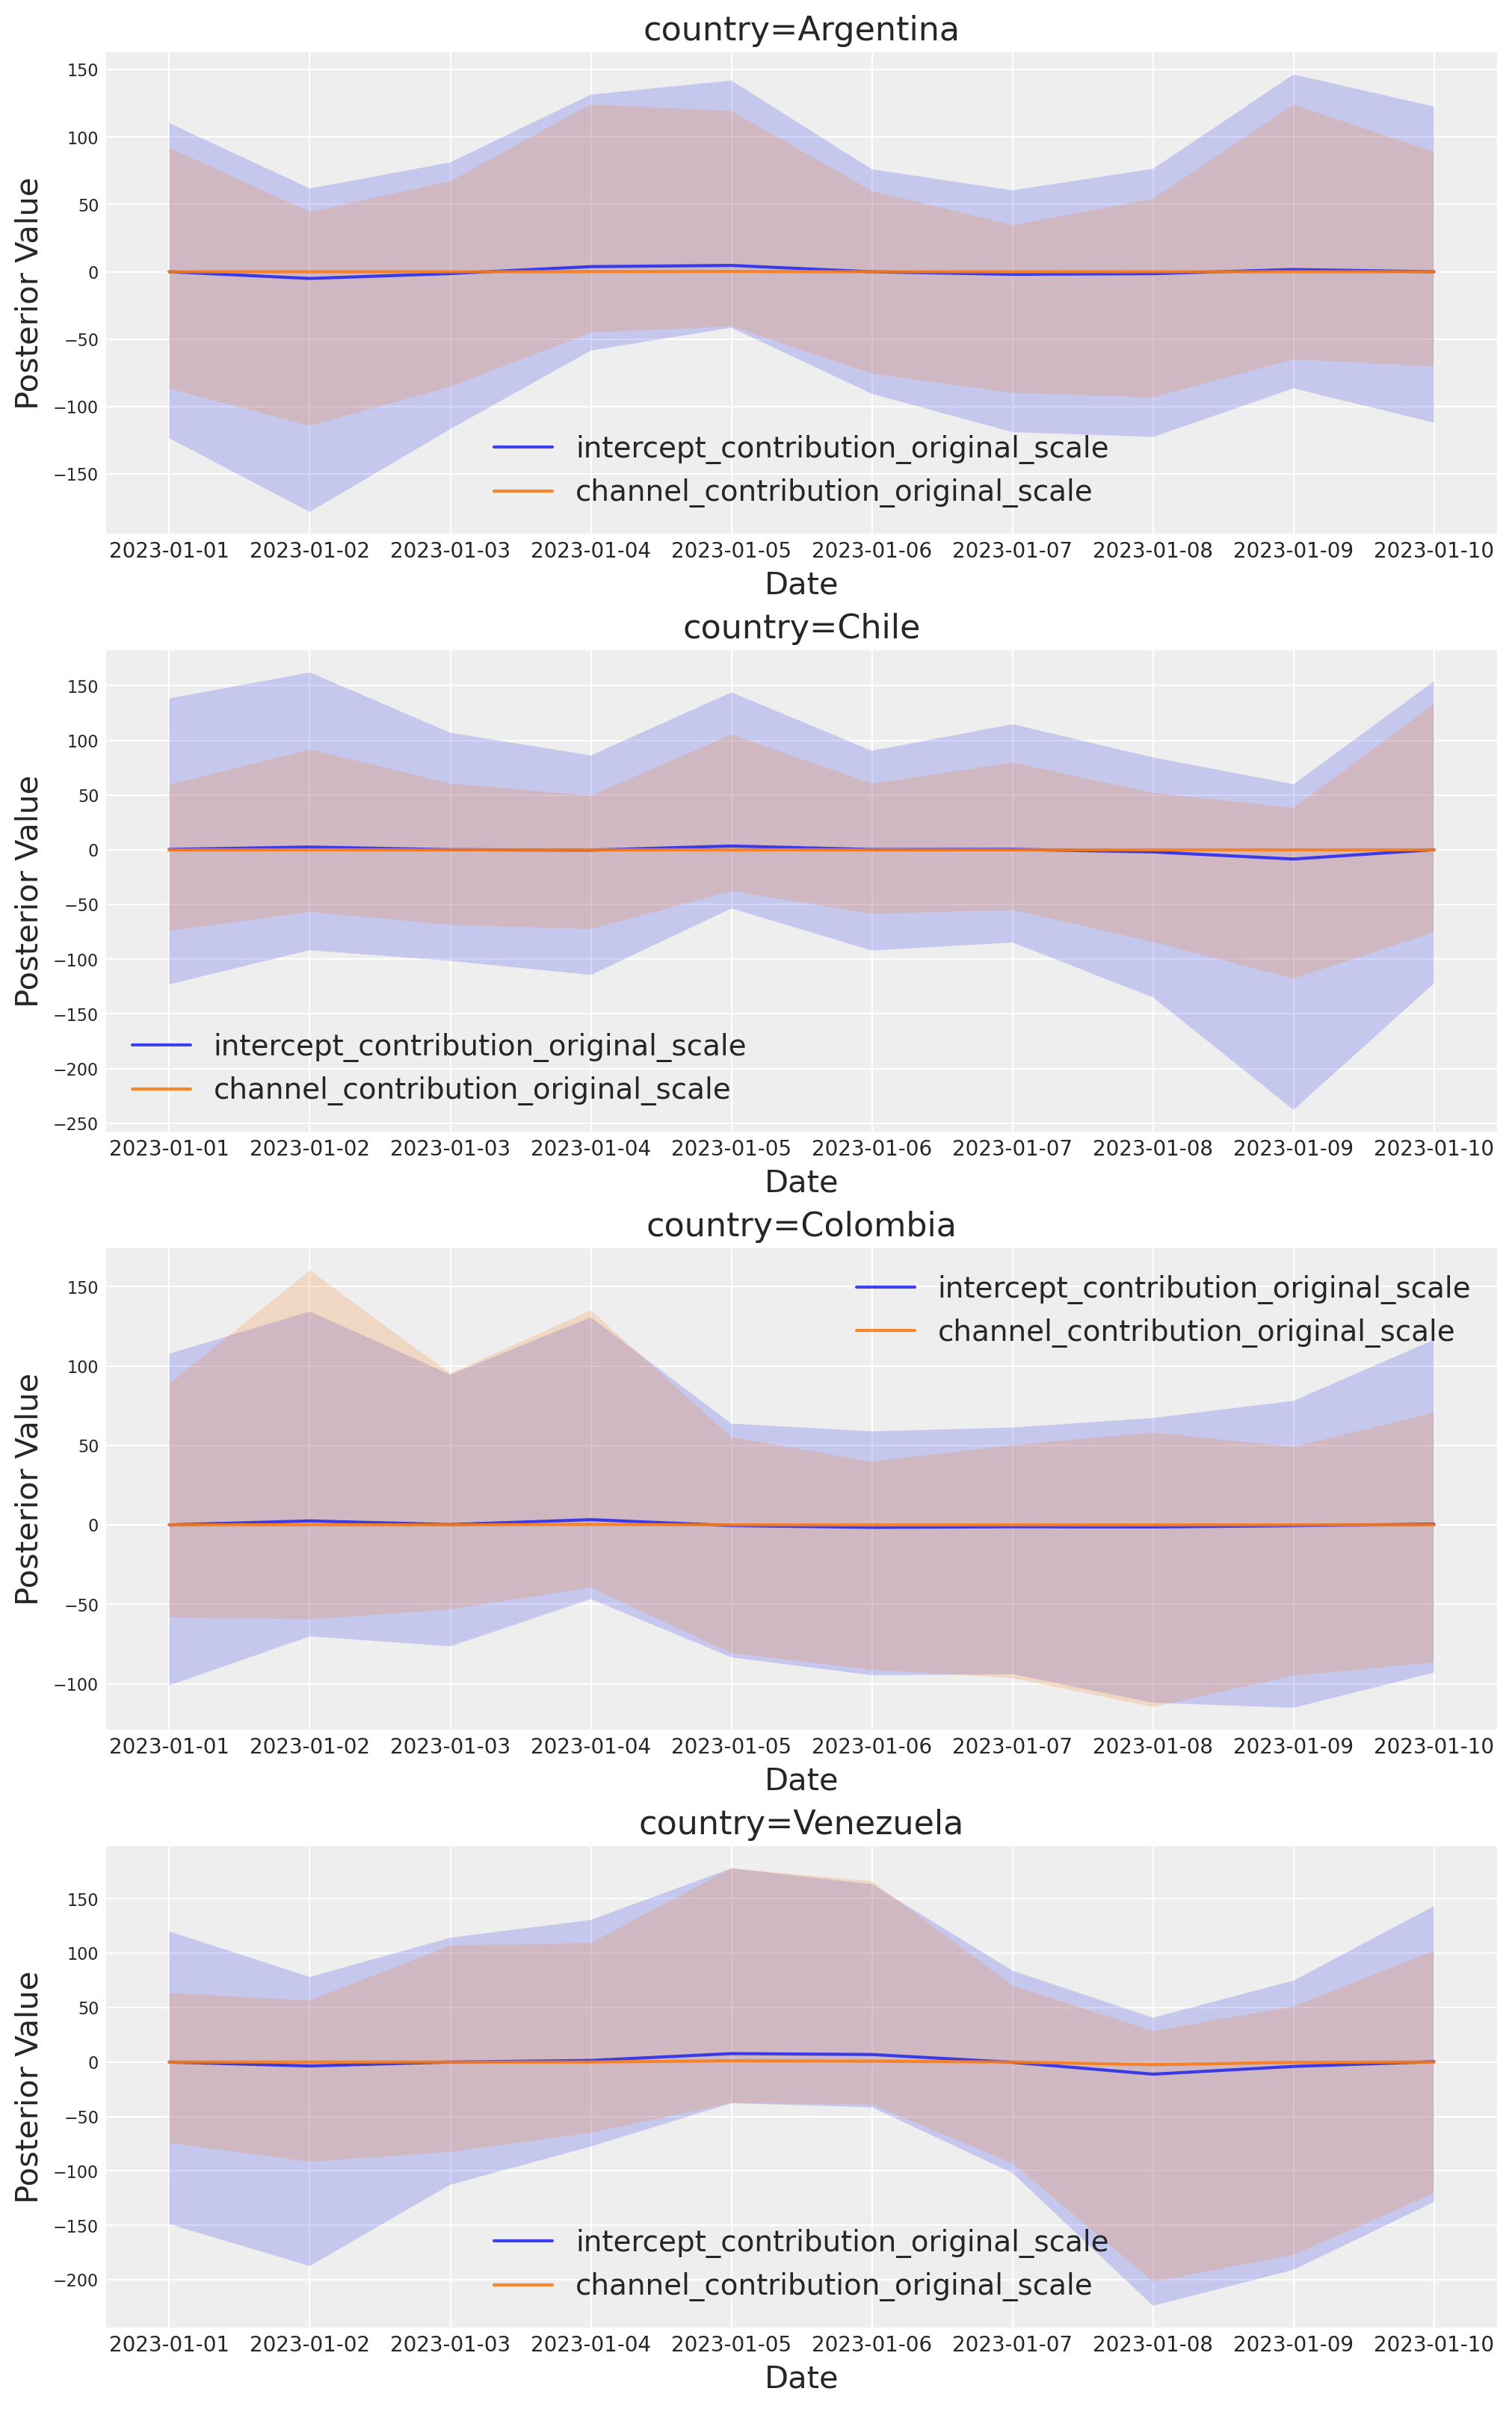

In [19]:
fig, ax = mmm.plot.contributions_over_time(
    var=[
        "intercept_contribution_original_scale",
        "channel_contribution_original_scale",
    ],
    ci=0.85,
)
# fig.set_size_inches(13, 15)

# # Change the size of the axis letters to be smaller
# for axis in ax.flatten():
#     axis.tick_params(axis="both", which="major", labelsize=10)
#     axis.tick_params(axis="both", which="minor", labelsize=8)

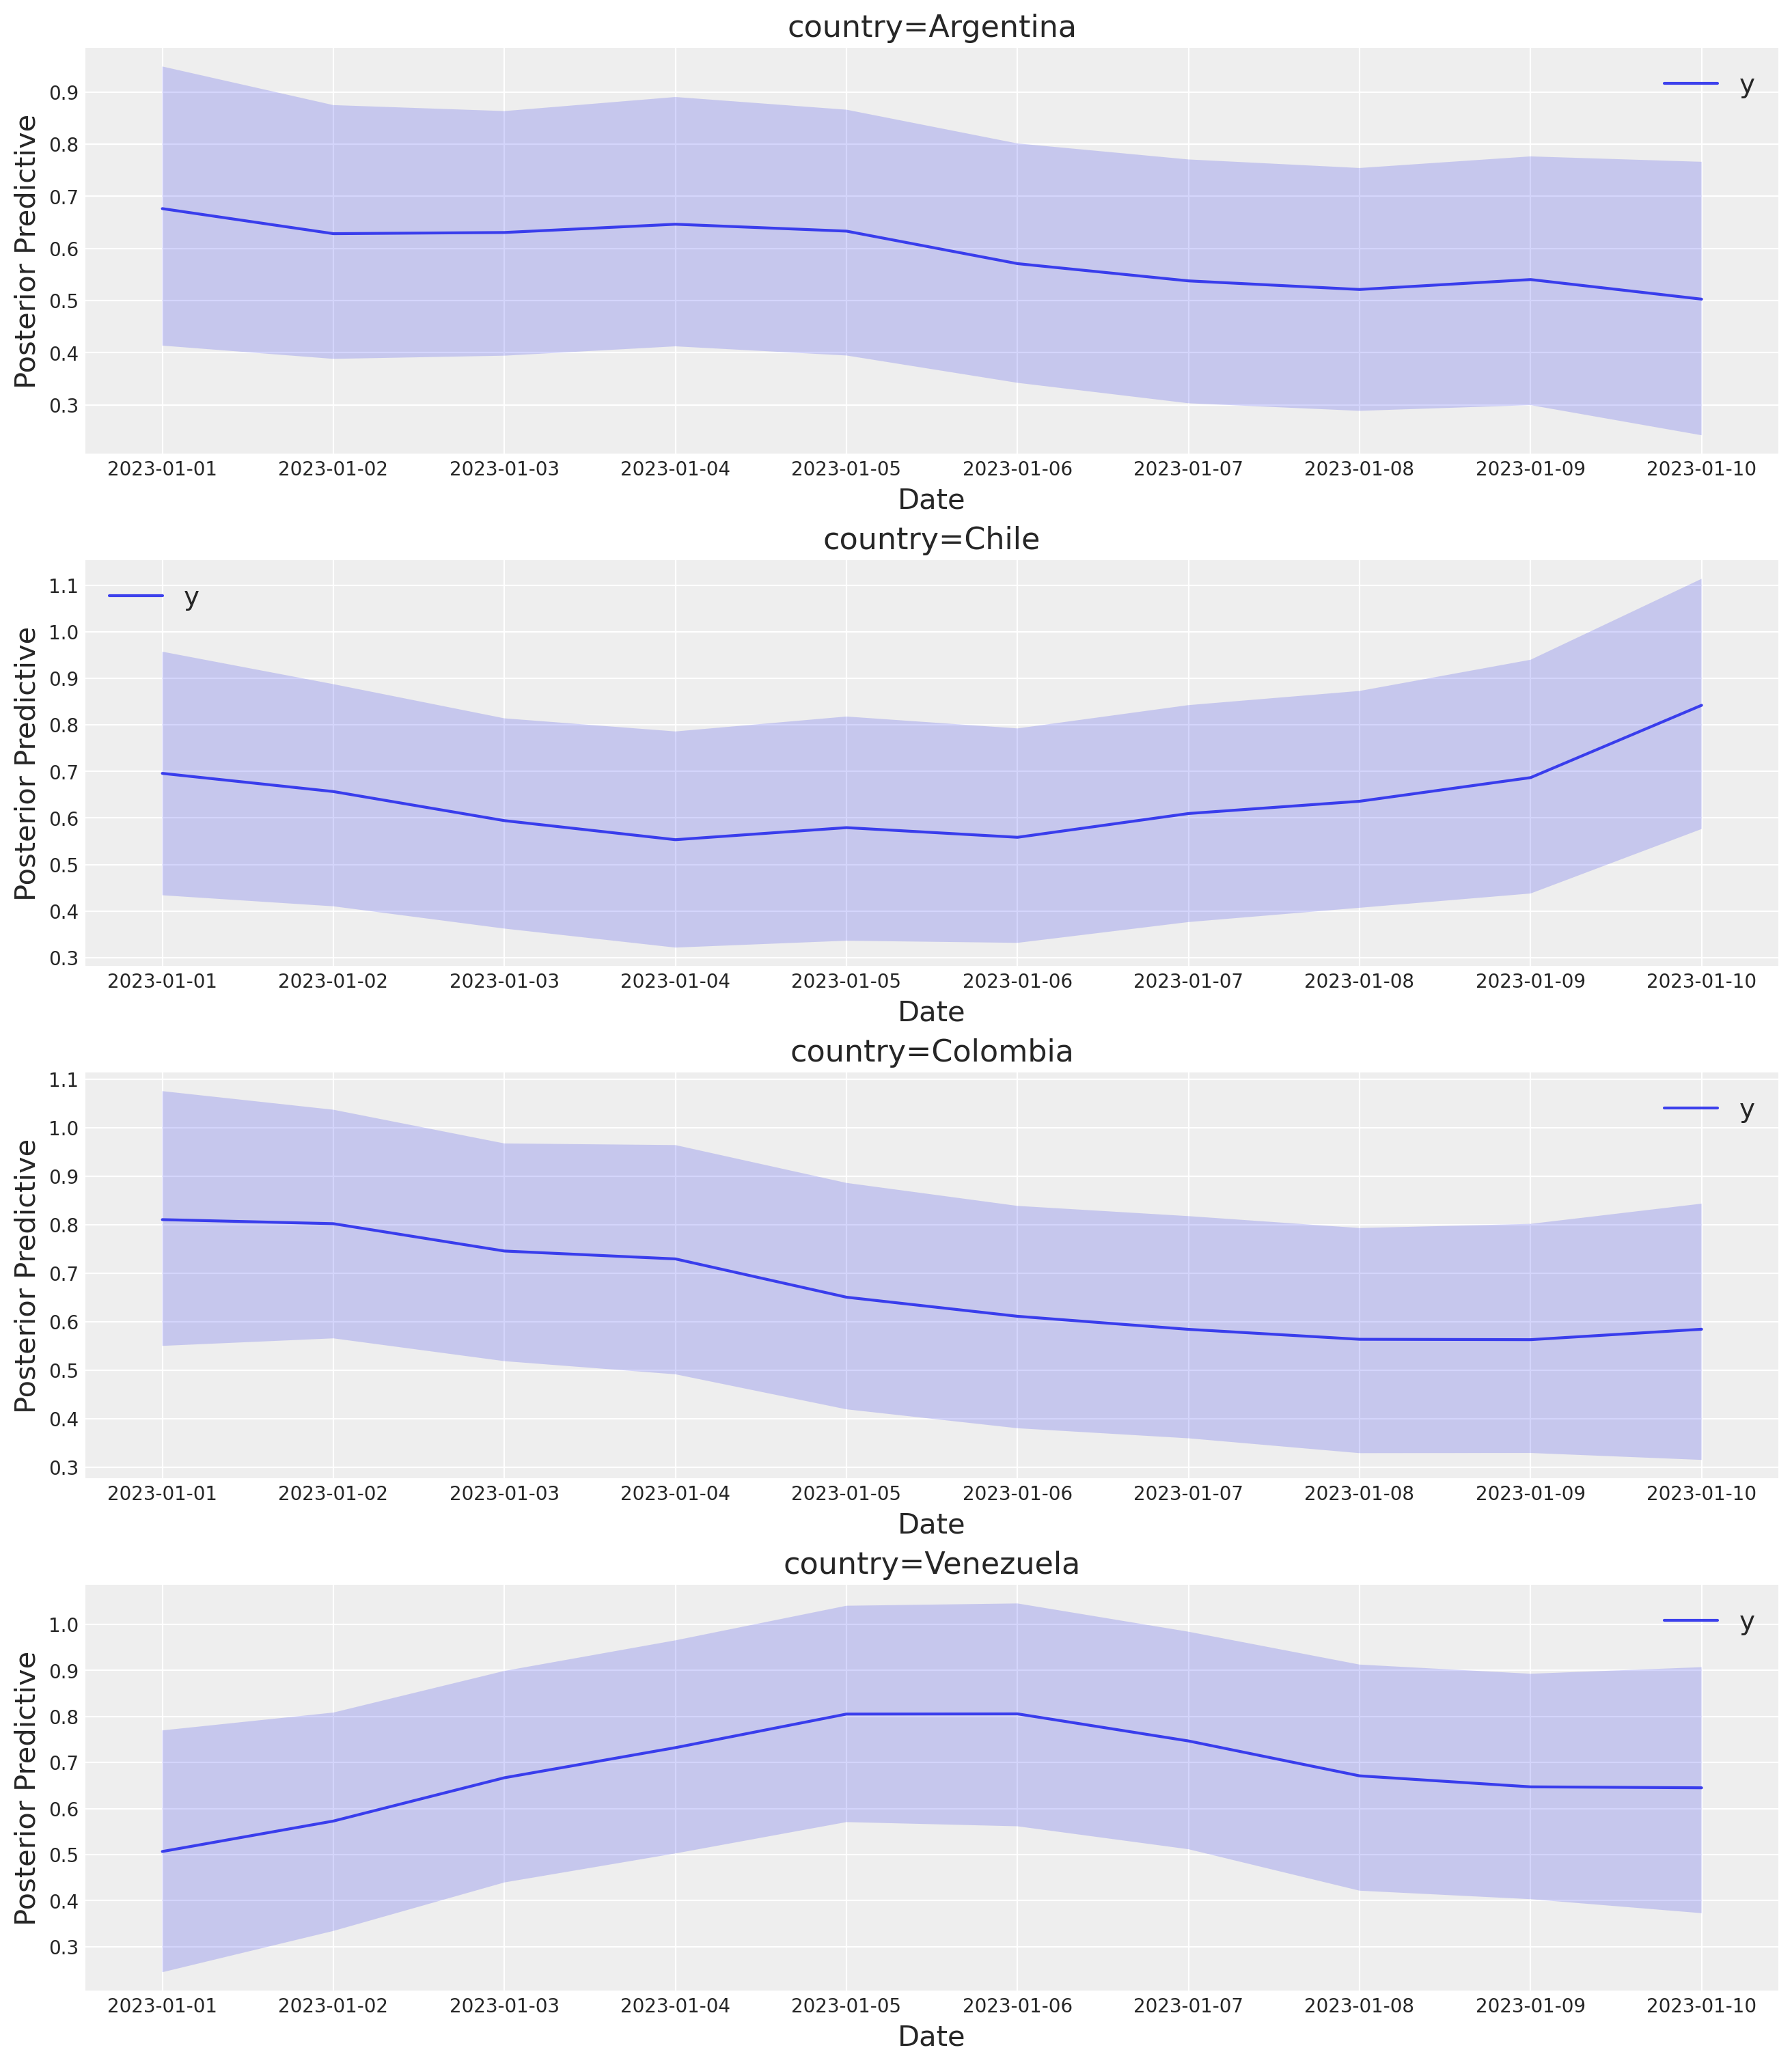

In [20]:
fig, ax = mmm.plot.posterior_predictive()
fig.set_size_inches(13, 15)

# Change the size of the axis letters to be smaller
for axis in ax.flatten():
    axis.tick_params(axis="both", which="major", labelsize=10)
    axis.tick_params(axis="both", which="minor", labelsize=8)

In [21]:
mmm.idata

Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> observed_data
	> constant_data

In [22]:
mmm.idata.posterior[["saturation_alpha", "saturation_lam"]]

<xarray.Dataset> Size: 328kB
Dimensions:           (chain: 4, draw: 1000, channel: 2, country: 4)
Coordinates:
  * chain             (chain) int64 32B 0 1 2 3
  * draw              (draw) int64 8kB 0 1 2 3 4 5 6 ... 994 995 996 997 998 999
  * country           (country) <U9 144B 'Argentina' 'Chile' ... 'Venezuela'
  * channel           (channel) <U1 8B 'a' 'b'
Data variables:
    saturation_alpha  (chain, draw, channel, country) float64 256kB 0.9401 .....
    saturation_lam    (chain, draw, channel) float64 64kB 1.182 1.497 ... 0.2443
Attributes:
    created_at:                 2025-01-31T11:22:29.231928+00:00
    arviz_version:              0.20.0
    inference_library:          numpyro
    inference_library_version:  0.16.1
    sampling_time:              31.344553
    tuning_steps:               1000

In [23]:
mmm.saturation

MichaelisMentenSaturation(prefix='saturation', priors={'alpha': Prior("Gamma", mu=Prior("HalfNormal", sigma=1, dims="country"), sigma=Prior("HalfNormal", sigma=1, dims="country"), dims=("channel", "country")), 'lam': Prior("HalfNormal", sigma=1, dims="channel")})

In [24]:
mmm = MMM(
    date_column="date",
    target_column="target",
    channel_columns=["a", "b"],
    # dims=("country",),
    adstock=GeometricAdstock(l_max=8),
    saturation=MichaelisMentenSaturation(),
)

# df.drop(columns="country", inplace=True)

In [25]:
mmm.fit(
    X=df.drop(columns=["country", "target"]), y=df.drop(columns=[*channels, "country"])
)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept_contribution, adstock_alpha, saturation_alpha, saturation_lam, y_sigma]
/opt/anaconda3/envs/pymc-marketing-dev/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Output()

/opt/anaconda3/envs/pymc-marketing-dev/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 5 seconds.
There were 101 divergences after tuning. Increase `target_accept` or reparameterize.
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


Inference data with groups:
	> posterior
	> sample_stats
	> observed_data
	> constant_data

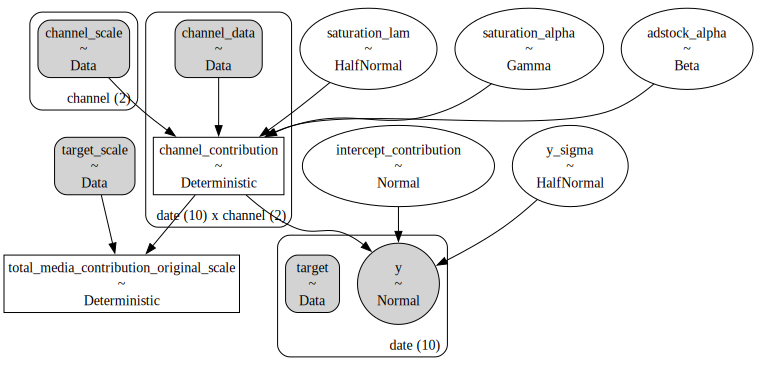

In [26]:
pm.model_to_graphviz(mmm.model)